# **Introduction**

___

## **Fine-Tuning SomBERTa and Benchmarking Against Other Models**

In this notebook, we fine-tune **SomBERTa**, a language model specifically pre-trained for Somali, and benchmark its performance against other pre-trained models (including AfriBERT, AfroXLMR and other BERT variants) across 4 tasks using 3 different datasets. The primary objective is to evaluate how well SomBERTa performs in comparison to general multilingual and other language models on Somali-specific NLP tasks.

### Datasets and Tasks
1. **Toxic Comment Classification**:
   - **Binary Classification**: Classifying comments as either toxic or non-toxic.
   - **Multi-Label Classification**: Categorizing toxic comments into specific types such as abuse, insult, threat, etc.
2. **MasakhaNEWS Topic Classification**:
   - **News Topic Classification**: Classifying news articles into topics like business, health, politics, sports, and technology.

3. **Fake News Detection**:
   - **Binary Classification**: Classifying news articles as either fake or real.

### Objectives
- **Evaluate SomBERTa**: Fine-tune and assess SomBERTa’s performance on each of the 4 tasks to determine its effectiveness for Somali-specific applications.
- **Benchmark Against Other Models**: Fine-tune and evaluate AfriBERTa, AfroXLMR, BERT, DistilBERT, RoBERTa, ALBERT, and mBERT on the same tasks to provide a comparative analysis. This approach helps establish SomBERTa's strengths and weaknesses relative to these other models, guiding future development and model selection for Somali NLP applications.

By the end of this notebook, we will gain insights into the performance of SomBERTa on diverse Somali NLP tasks, as well as its competitiveness against other pre-trained models.


# **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


___

# **Required Libraries**

In [ ]:
import pandas as pd
import os
import csv
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

# **Datasets**

## **Load Fine-Tuning Datasets**

In [ ]:

path = '/content/drive/MyDrive/AA_V2/fine-tuning-datasets'

# Toxic Comment Classification Dataset
# t_df = pd.read_csv(f'{path}/Toxic_Dataset.csv')

# Masakane News Classification Dataset
m_train_df = pd.read_csv(f'{path}/train.tsv', sep='\t')
m_test_df = pd.read_csv(f'{path}/test.tsv', sep='\t')

# Fake News Classification Dataset
# fn_df = pd.read_csv(f'{path}/fakenews dataset.csv')


### ***Description of Masakane News Classification Dataset***

In [ ]:
m_train_df.head()

,category,headline,text,url
0,politics,Mareykanka dad ka badan 40 qof oo tahriibayaal...,Ugu yaraan 46 qof oo la rumeysan yahay in ay ...,https://www.bbc.com/somali/war-61962361
1,politics,Warar sheegaya in la sii daayay badmaaxayaashi...,Toban badmaax oo u dhashay dalka Turkiga oo bi...,https://www.bbc.com/somali/war-49303460
2,politics,Doorashada Mareykanka 2020: Dadka Mareykanka o...,Donald Trump ayaa muddo isbuucyo ah sheegayay ...,https://www.bbc.com/somali/war-54813950
3,business,Shan arrimood oo ku saabsan isticmaalka khudra...,Beytaraafka waa khudrad muhiim ah oo ka qeyb q...,https://www.bbc.com/somali/61371455
4,politics,Waxyaabaha u gaarka ah gawaarida qaybta ka ah ...,Waxyaabaha ay dadku sida aadka ah u xiiseeyaan...,https://www.bbc.com/somali/war-60298334


In [ ]:
print("**************** Masakane News Train Data ****************")
# Masakane Train Data
m_train_df.info()

print("\n**************** Masakane News Test Data ****************")
# Masakane Test Data
m_test_df.info()

**************** Masakane News Train Data ****************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1021 non-null   object
 1   headline  1021 non-null   object
 2   text      1021 non-null   object
 3   url       1021 non-null   object
dtypes: object(4)
memory usage: 32.0+ KB

**************** Masakane News Test Data ****************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  294 non-null    object
 1   headline  294 non-null    object
 2   text      294 non-null    object
 3   url       294 non-null    object
dtypes: object(4)
memory usage: 9.3+ KB


The Masakane News Classification Dataset (Somali subset) is used to fine-tune SomBERTa and other pre-trained models for Somali news content classification. This dataset, part of the Masakane community project as detailed by Adelani et al. (2023) in MasakhaNEWS: News Topic Classification for African Languages, includes 1,021 training entries and 294 test entries, each with the following attributes:

- **category**: News category (e.g., politics, health, sports).
- **headline**: News article headline.
- **text**: Full text of the news article.
- **url**: URL of the original source

The Masakane dataset contains 1,021 rows and 4 columns for training, and 294 rows for testing, with no missing data.

# **Data Preprocessing**

## Checking and deduplicating the data.

In [ ]:
# List of dataframes and their names
dataframes = [m_train_df, m_test_df]
df_names = ['MasakaNEWS Train', 'MasakaNEWS Test']

# let us check the duplicated rows in any df.
def check_duplicates(dataframes, df_names):
    result = []

    for i, df in enumerate(dataframes):
        # Count duplicated rows
        duplicate_count = df.duplicated().sum()
        result.append({
            'DataFrame': df_names[i],
            'Total Rows': len(df),
            'Duplicated Rows': duplicate_count
        })

    # Create a summary DataFrame
    summary_df = pd.DataFrame(result)

    return summary_df

In [ ]:
# Checking duplicates
check_duplicates(dataframes, df_names)

This above table depicts that there are duplicates in the Toxic dataset only.

In [ ]:
# Function to remove duplicates from dataframes
def remove_duplicates(dataframes, df_names):
    cleaned_dataframes = {}
    cleaned_dataframes_list = []

    for i, df in enumerate(dataframes):
        # Remove duplicated rows and reset the index
        cleaned_df = df.drop_duplicates().reset_index(drop=True)
        cleaned_dataframes[df_names[i]] = cleaned_df
        cleaned_dataframes_list.append(cleaned_df)

    return cleaned_dataframes, cleaned_dataframes_list

# Remove duplicates
cleaned_df_dict, dataframes = remove_duplicates(dataframes, df_names)

# Access individual cleaned DataFrames
m_train_df = cleaned_df_dict['MasakaNEWS Train']
m_test_df = cleaned_df_dict['MasakaNEWS Test']


In [ ]:
# Check again
check_duplicates(dataframes, df_names)

## **Data Cleaning**

According to MasakaNEWS paper, we decided to concatenate headline and text fields into a single text field to get a better result.

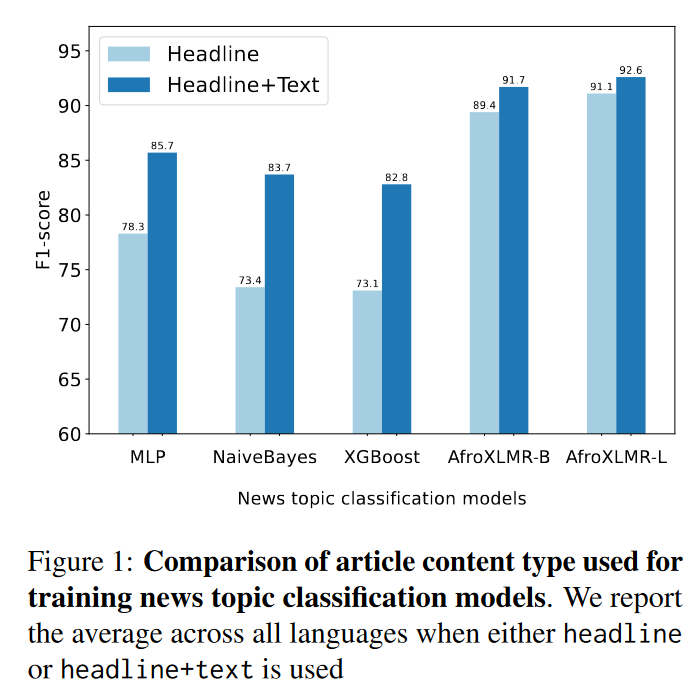

The above imperical work shows the output of the MasakaNEWS paper when they concatenate headline and text columns.

In [ ]:
# Concatenate 'headline' and 'text' into a new 'text' column
m_train_df['text'] = m_train_df['headline'] + " " + m_train_df['text']

# Drop the 'url' column
m_train_df = m_train_df.drop(columns=['url', 'headline'])

m_train_df.head()

,category,text
0,politics,Mareykanka dad ka badan 40 qof oo tahriibayaal...
1,politics,Warar sheegaya in la sii daayay badmaaxayaashi...
2,politics,Doorashada Mareykanka 2020: Dadka Mareykanka o...
3,business,Shan arrimood oo ku saabsan isticmaalka khudra...
4,politics,Waxyaabaha u gaarka ah gawaarida qaybta ka ah ...


In [ ]:
# For test set
m_test_df['text'] = m_test_df['headline'] + " " + m_test_df['text']
m_test_df = m_test_df.drop(columns=['url', 'headline'])

m_test_df.head()

,category,text
0,business,Kenya: Nin dumarka 60 jirka ah si khiyaano ah ...
1,business,"Dalalka Afrika ma waxay ku dhaceen ""dabinka de..."
2,business,Maxaad ka ogtahay canugga ugu taajirsan dunida...
3,business,"Muraayaddan ma siisan lahayd £15,000? Muraayad..."
4,business,Dheeman hal bilyan oo sano jiray iyo lacagta l...


In [ ]:
m_train_df.category.value_counts()

,count
category,
politics,350
health,247
sports,103
entertainment,97
technology,94
business,79
religion,51


Before preprocessing...

### **Cleaning...**

In [ ]:
import re
import unicodedata

# Somali alphabet
SOMALI_ALPHABET = (
    "aA" "bB" "cC" "dD" "eE" "fF" "gG" "hH" "iI" "jJ" "kK" "lL" "mM" "nN"
    "oO" "qQ" "rR" "sS" "tT" "uU" "wW" "xX" "yY"
)

ALLOWED_CHARS = SOMALI_ALPHABET + "0123456789 ,.!?()-'"  # Numbers and standard punctuation

def preprocessor(text):
    text = unicodedata.normalize("NFKD", text)  # Normalize text to NFKD form to handle accented characters and other unicode variations
    text = ''.join([char for char in text if not unicodedata.combining(char)])  # Remove diacritics (accents) while keeping Somali alphabet characters
    text = text.lower()  # Lowercase the text (useful for BERT pretraining)
    text = ''.join([char for char in text if char in ALLOWED_CHARS.lower()])  # Remove unwanted characters based on ALLOWED_CHARS
    text = re.sub(r'([,.!?()-])\1+', r'\1', text)  # Replace multiple consecutive punctuation marks with a single occurrence
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space and trim leading/trailing spaces
    return text


In [ ]:
# Function to clean and preprocess a DataFrame dynamically based on the column name
def clean_dataframe(df, text_column):
    # Check if the text column exists in the dataframe
    if text_column in df.columns:
        # Apply preprocessing function to the specified text column
        df[text_column] = df[text_column].fillna('').apply(preprocessor)
    else:
        print(f"Column '{text_column}' not found in dataframe")

    return df


text_columns = ['text', 'text']

# Apply the cleaning function to each dataframe and corresponding text column
for i, df in enumerate(dataframes):
    dataframes[i] = clean_dataframe(df, text_columns[i])
    print(f"{df_names[i]} with column '{text_columns[i]}' has been cleaned")


After Cleaning...

In [ ]:
m_train_df.Comment[3]

It is clear that we preprocessed the data properly.

In [ ]:
tm_train_df.head()

## **Train-test Split**

In [ ]:
df = t_df.copy()

In [ ]:
from sklearn.model_selection import train_test_split

# Method for splitting data into training and evaluation sets
def perform_train_test_split(X, y, test_size=0.2, stratify=None, random_state=42, task_name="Task"):
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=test_size, stratify=stratify, random_state=random_state
    )

    print(f"{task_name}: Training samples: {len(train_X)}, Evaluation samples: {len(test_X)}")
    return train_X, test_X, train_y, test_y


# Separating features and labels in MasakaNEWS dataset
train_texts_mn = m_train_df['text'].tolist()
train_labels_mn = m_train_df['category'].tolist()
eval_texts_mn = m_test_df['text'].tolist()
eval_labels_mn = m_test_df['category'].tolist()
print(f"MasakaNEWS: Training samples: {len(train_texts_mn)}, Evaluation samples: {len(eval_texts_mn)}")


---

# **TASK 1: MASAKANEWS DATASET (Multi-Class Task)**

### **Tokenize, Prepare, and Fine-Tune Models on MasakaNEWS Data**

In [ ]:
# Imports
from torch.utils.data import Dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertForSequenceClassification , BertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define Categories...
category_list = ['business', 'entertainment', 'health', 'politics', 'religion', 'sports', 'technology']

# 1. Define Custom Dataset Class
class MultiClassDataset(Dataset):
    """
    Dataset class for multi-class classification with support for custom encodings and labels.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# 2. Data Preparation Functions
def convert_labels_to_tensor(labels, category_to_id):
    """
    Convert multi-class labels into a binary tensor suitable for multi-label classification.
    """
    labels_tensor = torch.zeros((len(labels), len(category_to_id)), dtype=torch.float)
    for idx, label in enumerate(labels):
        label_idx = category_to_id[label]
        labels_tensor[idx][label_idx] = 1.0
    return labels_tensor

def tokenize_texts(texts, tokenizer, max_length=512):
    """
    Tokenize input texts using a specified tokenizer.
    """
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

def prepare_data(texts, labels, tokenizer, category_to_id, max_length=512):
    """
    Process the data into encodings and label tensors for model training.
    """
    encodings = tokenize_texts(texts, tokenizer, max_length=max_length)
    labels_tensor = convert_labels_to_tensor(labels, category_to_id)
    return encodings, labels_tensor

# 3. Metrics Computation Function
def compute_metrics(eval_pred, threshold=0.5):
    """
    Compute metrics for multi-label classification with a customizable threshold.
    """
    logits, labels = eval_pred
    preds = (logits >= threshold).astype(int)
    accuracy = (preds == labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# 4. Training and Evaluation Function
def train_and_evaluate(model_name, train_texts, train_labels, eval_texts, eval_labels,
                       max_length=512, epochs=6, batch_size=8, lr=5.31e-05, weight_decay=0.001, use_sombert=False):
    """
    Train and evaluate the model with the provided data and parameters.
    """
    category_to_id = {category: idx for idx, category in enumerate(category_list)}

    if use_sombert:
      tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/AA/SomeBERTaModel/somberta_tokenizer_70k") # SomBERTa Tokenizer path...
    else:
      tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare data
    train_encodings, train_labels_tensor = prepare_data(train_texts, train_labels, tokenizer, category_to_id, max_length=max_length)
    eval_encodings, eval_labels_tensor = prepare_data(eval_texts, eval_labels, tokenizer, category_to_id, max_length=max_length)

    train_dataset = MultiClassDataset(train_encodings, train_labels_tensor)
    eval_dataset = MultiClassDataset(eval_encodings, eval_labels_tensor)

    # Choose the model based on use_sombert flag
    if use_sombert:
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(category_list))
    else:
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(category_list))

    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
        logging_dir="./logs",
        logging_steps=15,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    # Train and evaluate
    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results

def train_and_eval(model_path, use_sombert=False):
    return train_and_evaluate(
        model_name=model_path,
        train_texts=train_texts_mn,
        train_labels=train_labels_mn,
        eval_texts=eval_texts_mn,
        eval_labels=eval_labels_mn,
        use_sombert=use_sombert
    )

## **1. SomBERTa**

In [ ]:
somBERTa = "/content/drive/MyDrive/AA/SomeBERTaModel/SomBERTa-large" # change this path with accual one "shuakshay/somberta"
train_and_eval(model_path=somBERTa,use_sombert=True)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/AA/SomeBERTaModel/SomBERTa-large and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.209900,0.213029,0.924684,0.700641,0.537415,0.600016
2,0.136600,0.188332,0.935860,0.853714,0.673469,0.735967
3,0.059700,0.185012,0.937318,0.809976,0.731293,0.764126
4,0.033400,0.186998,0.942177,0.823223,0.758503,0.788891
5,0.015500,0.197076,0.943149,0.824405,0.761905,0.791411
6,0.014200,0.200447,0.941691,0.819368,0.758503,0.787196


Evaluation Results: {'eval_loss': 0.2004474401473999, 'eval_accuracy': 0.9416909620991254, 'eval_precision': 0.8193683638212514, 'eval_recall': 0.7585034013605442, 'eval_f1': 0.7871961058632634, 'eval_runtime': 6.5535, 'eval_samples_per_second': 44.861, 'eval_steps_per_second': 5.646, 'epoch': 6.0}


{'eval_loss': 0.2004474401473999,
 'eval_accuracy': 0.9416909620991254,
 'eval_precision': 0.8193683638212514,
 'eval_recall': 0.7585034013605442,
 'eval_f1': 0.7871961058632634,
 'eval_runtime': 6.5535,
 'eval_samples_per_second': 44.861,
 'eval_steps_per_second': 5.646,
 'epoch': 6.0}

## **2. AfriBERTa**

In [ ]:
train_and_eval("castorini/afriberta_large")


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.214300,0.230885,0.918853,0.675592,0.544218,0.578954
2,0.168700,0.155886,0.947522,0.910944,0.693878,0.767016
3,0.087100,0.144845,0.952381,0.872439,0.782313,0.818990
4,0.063700,0.149258,0.952381,0.862166,0.795918,0.824080
5,0.038900,0.154298,0.948980,0.850310,0.785714,0.812237
6,0.026900,0.150339,0.952381,0.860864,0.802721,0.827989


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


Evaluation Results: {'eval_loss': 0.15033893287181854, 'eval_accuracy': 0.9523809523809523, 'eval_precision': 0.8608637445660982, 'eval_recall': 0.8027210884353742, 'eval_f1': 0.8279892715066874, 'eval_runtime': 6.8828, 'eval_samples_per_second': 42.715, 'eval_steps_per_second': 5.376, 'epoch': 6.0}


{'eval_loss': 0.15033893287181854,
 'eval_accuracy': 0.9523809523809523,
 'eval_precision': 0.8608637445660982,
 'eval_recall': 0.8027210884353742,
 'eval_f1': 0.8279892715066874,
 'eval_runtime': 6.8828,
 'eval_samples_per_second': 42.715,
 'eval_steps_per_second': 5.376,
 'epoch': 6.0}

## **3. AfroXLMR**

In [ ]:
train_and_eval("Davlan/afro-xlmr-base")


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.203100,0.200393,0.933916,0.773183,0.632653,0.654958
2,0.144800,0.147454,0.953839,0.877523,0.785714,0.823535
3,0.079600,0.147914,0.954325,0.874456,0.789116,0.826729
4,0.071600,0.133569,0.958212,0.876508,0.823129,0.845513
5,0.042200,0.123187,0.962099,0.887323,0.840136,0.862539
6,0.022500,0.130448,0.957726,0.868878,0.829932,0.847857


Evaluation Results: {'eval_loss': 0.13044773042201996, 'eval_accuracy': 0.9577259475218659, 'eval_precision': 0.8688783714544019, 'eval_recall': 0.8299319727891157, 'eval_f1': 0.8478569628059305, 'eval_runtime': 8.9601, 'eval_samples_per_second': 32.812, 'eval_steps_per_second': 4.129, 'epoch': 6.0}


{'eval_loss': 0.13044773042201996,
 'eval_accuracy': 0.9577259475218659,
 'eval_precision': 0.8688783714544019,
 'eval_recall': 0.8299319727891157,
 'eval_f1': 0.8478569628059305,
 'eval_runtime': 8.9601,
 'eval_samples_per_second': 32.812,
 'eval_steps_per_second': 4.129,
 'epoch': 6.0}

## **4. BERT**

In [ ]:
train_and_eval("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.366800,0.362992,0.857143,0.000000,0.000000,0.000000
2,0.292300,0.282842,0.903790,0.631771,0.486395,0.517303
3,0.227400,0.236850,0.918367,0.653878,0.530612,0.584705
4,0.192400,0.223217,0.922741,0.715335,0.602041,0.640185
5,0.128400,0.228403,0.922741,0.726410,0.598639,0.653432
6,0.093200,0.226306,0.925656,0.736889,0.625850,0.670115


{'eval_loss': 0.2263055145740509,
 'eval_accuracy': 0.9256559766763849,
 'eval_precision': 0.736889478165081,
 'eval_recall': 0.6258503401360545,
 'eval_f1': 0.6701153018748831,
 'eval_runtime': 8.2344,
 'eval_samples_per_second': 35.704,
 'eval_steps_per_second': 4.493,
 'epoch': 6.0}

## **5. RoBERTa**

In [ ]:
train_and_eval("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.376800,0.377951,0.857143,0.000000,0.000000,0.000000
2,0.370900,0.376649,0.857143,0.000000,0.000000,0.000000
3,0.386500,0.375893,0.857143,0.000000,0.000000,0.000000
4,0.385300,0.376121,0.857143,0.000000,0.000000,0.000000
5,0.384900,0.374842,0.857143,0.000000,0.000000,0.000000
6,0.389100,0.374742,0.857143,0.000000,0.000000,0.000000


{'eval_loss': 0.3747415840625763,
 'eval_accuracy': 0.8571428571428571,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_runtime': 9.4095,
 'eval_samples_per_second': 31.245,
 'eval_steps_per_second': 3.932,
 'epoch': 6.0}

## **6. DistillBERT**

In [ ]:
train_and_eval("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.375000,0.372132,0.857143,0.000000,0.000000,0.000000
2,0.306000,0.279881,0.895530,0.461730,0.326531,0.378773
3,0.211100,0.232834,0.920311,0.708174,0.554422,0.607674
4,0.166000,0.220596,0.922255,0.718222,0.585034,0.634152
5,0.148600,0.227607,0.920311,0.790071,0.622449,0.667041
6,0.088400,0.220249,0.926628,0.793302,0.646259,0.695883


{'eval_loss': 0.22024889290332794,
 'eval_accuracy': 0.9266277939747327,
 'eval_precision': 0.793301936159079,
 'eval_recall': 0.6462585034013606,
 'eval_f1': 0.6958829442354914,
 'eval_runtime': 4.6805,
 'eval_samples_per_second': 62.814,
 'eval_steps_per_second': 7.905,
 'epoch': 6.0}

## **7. ABERT**

In [ ]:
train_and_eval("albert-base-v2")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.377300,0.375569,0.857143,0.000000,0.000000,0.000000
2,0.373400,0.375836,0.857143,0.000000,0.000000,0.000000
3,0.368600,0.357945,0.862974,0.088435,0.044218,0.058957
4,0.365300,0.356725,0.862974,0.088435,0.044218,0.058957
5,0.343400,0.351840,0.862974,0.088435,0.044218,0.058957
6,0.333300,0.348624,0.862974,0.088435,0.044218,0.058957


{'eval_loss': 0.34862425923347473,
 'eval_accuracy': 0.8629737609329446,
 'eval_precision': 0.08843537414965986,
 'eval_recall': 0.04421768707482993,
 'eval_f1': 0.05895691609977325,
 'eval_runtime': 10.4728,
 'eval_samples_per_second': 28.073,
 'eval_steps_per_second': 3.533,
 'epoch': 6.0}

## **8. mBERT**

In [ ]:
train_and_eval("bert-base-multilingual-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.327400,0.316614,0.867347,0.575825,0.115646,0.172332
2,0.271300,0.261449,0.910593,0.659254,0.465986,0.540533
3,0.214800,0.235923,0.917881,0.764889,0.530612,0.615329
4,0.171400,0.222191,0.925656,0.730898,0.639456,0.674758
5,0.119700,0.218643,0.928086,0.749745,0.646259,0.689320
6,0.085700,0.217152,0.930515,0.803351,0.673469,0.716336


{'eval_loss': 0.21715161204338074,
 'eval_accuracy': 0.9305150631681244,
 'eval_precision': 0.8033513069910271,
 'eval_recall': 0.673469387755102,
 'eval_f1': 0.7163355762512817,
 'eval_runtime': 8.2247,
 'eval_samples_per_second': 35.746,
 'eval_steps_per_second': 4.499,
 'epoch': 6.0}

---

# **Conclusion**

---

In this notebook, we fine-tuned SomBERTa and a variety of other pre-trained models (AfriBERTa, AfroXLMR, BERT, DistilBERT, RoBERTa, ALBERT, and mBERT) across 4 tasks using 3 different datasets (Unfortuately, the other 3 tasks were private according to their data), with the goal of benchmarking SomBERTa's performance for Somali language tasks. Our analysis across tasks—ranging from toxic comment classification and fake news detection to news topic classification—provided key insights into each model's suitability for Somali NLP applications.

### Key Findings
- **SomBERTa’s Strengths**: SomBERTa, pre-trained on Somali data, consistently demonstrated strong performance, particularly in tasks requiring nuanced understanding of Somali language, such as toxic comment classification and topic classification.
- **AfriBERTa and AfroXLMR are Competitive Multilingual Capabilities**: Despite being multilingual models, both of them showed competitive performance in task 1, classifying news topics using MasakaNEWS data, highlighting their versatility and potential as strong baselines for low-resource African languages.
- **Comparative Analysis of BERT Variants**: Our benchmarking results across BERT, DistilBERT, RoBERTa, ALBERT, and mBERT provided a comprehensive view of model strengths and weaknesses. This comparison highlighted areas where SomBERTa excels, as well as cases where other BERT variants may offer advantages.

### Key Takeaways
- **Model Selection for Task-Specific Applications**: SomBERTa appears particularly well-suited for Somali-specific tasks due to its language-specific pre-training, while AfriBERTa, AfroXLMR, and other BERT variants remain viable for multilingual applications or as general baselines.
- **Future Directions**: Additional fine-tuning with Somali-specific datasets or exploring domain-specific datasets for fine-tuning could further improve SomBERTa’s performance and applicability across more tasks.

This notebook provides a strong foundation for Somali NLP, offering guidance on model selection for diverse applications and informing future development in the field.
